In [1]:
import zarrdataset as zds

import torch
from torch.utils.data import DataLoader, ChainDataset

C:\Users\cervaf\Documents\Apps\miniconda3\envs\zds-dev\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# These are images from the Image Data Resource (IDR) 
# https://idr.openmicroscopy.org/ that are publicly available and were 
# converted to the OME-NGFF (Zarr) format by the OME group. More examples
# can be found at Public OME-Zarr data (Nov. 2020)
# https://www.openmicroscopy.org/2020/11/04/zarr-data.html

filenames = [
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001240.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001241.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001242.zarr",
    "https://uk1s3.embassy.ebi.ac.uk/idr/zarr/v0.1/6001243.zarr",
]

In [3]:
import random
import numpy as np

# For reproducibility
np.random.seed(478963)
torch.manual_seed(478964)
random.seed(478965)

In [4]:
patch_size = dict(Z=32, Y=128, X=128)
patch_sampler = zds.PatchSampler(patch_size=patch_size)

In [5]:
import torchvision

img_preprocessing = torchvision.transforms.Compose([
    zds.ToDtype(dtype=np.float16)
])

In [6]:
my_datasets = [
  zds.ZarrDataset(
    [
      zds.ImagesDatasetSpecs(
        filenames=fn,
        data_group="0",
        source_axes="TCZYX",
        transform=img_preprocessing,
      )
    ],
    patch_sampler=patch_sampler,
    shuffle=True,
    return_positions=True,
    return_worker_id=True
  )
  for fn in filenames
]

In [7]:
my_chain_dataset = ChainDataset(my_datasets)

In [8]:
my_dataloader = DataLoader(my_chain_dataset,
                           num_workers=4,
                           worker_init_fn=zds.chained_zarrdataset_worker_init_fn,
                           batch_size=2
                           )

In [9]:
samples = []
positions = []
wids = []
for i, (wid, pos, sample) in enumerate(my_dataloader):
    wids += [w for w in wid]
    positions += [p for p in pos]
    samples += [s for s in sample]    

    print(f"Sample {i+1} with size {sample.shape} extracted by worker {wid}.")

    if i >= 4:
        # Take five batches for illustration purposes
        break

samples = torch.cat(samples, dim=0)

samples.shape

Sample 1 with size torch.Size([2, 1, 2, 32, 128, 128]) extracted by worker tensor([0, 0]).
Sample 2 with size torch.Size([2, 1, 2, 32, 128, 128]) extracted by worker tensor([1, 1]).


Sample 3 with size torch.Size([2, 1, 2, 32, 128, 128]) extracted by worker tensor([2, 2]).
Sample 4 with size torch.Size([2, 1, 2, 32, 128, 128]) extracted by worker tensor([3, 3]).
Sample 5 with size torch.Size([2, 1, 2, 32, 128, 128]) extracted by worker tensor([0, 0]).


torch.Size([10, 2, 32, 128, 128])

In [10]:
samples_grid = torchvision.utils.make_grid(samples[:, :, 16, :, :])

(-0.5, 1041.5, 261.5, -0.5)

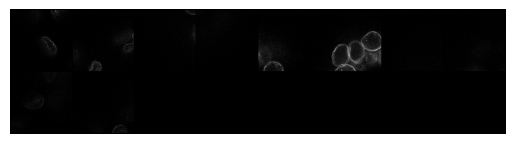

In [11]:
import matplotlib.pyplot as plt

plt.imshow(samples_grid[0], cmap="gray")
plt.axis('off')

(-0.5, 1041.5, 261.5, -0.5)

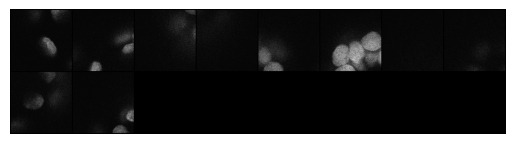

In [12]:
plt.imshow(samples_grid[1], cmap="gray")
plt.axis('off')